### Find latent features in Place cells using Matrioshka SAEs

Main goal: look at different levels of features in a 3-level MSAE

Steps:

1. Train MSAE on spikes dataset

2. Create (topk) sae feature df

3. Create stim (meta)data df

4. Interp / autointerp
    
    a. Create infra for finding stim at times of particular feature(s)
    
    b. Create infra for finding topk SAE features that fire at times of particular stim

In [56]:
"""Import packages."""

import math
from collections import defaultdict
from dataclasses import dataclass
from functools import partial
from pathlib import Path
from typing import Callable, List, Optional, Tuple

# import jax
import numpy as np
import pandas as pd
import seaborn as sns
import torch as t
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from IPython.display import HTML
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from plotly import express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from rich import print as rprint
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.linear_model import LinearRegression
from torch import bfloat16, nn, Tensor
from torch.nn import functional as F
from torcheval.metrics.functional import r2_score as tm_r2_score
from tqdm.notebook import tqdm

from mini import train as mt
from mini.util import vec_r2

In [57]:
"""Set notebook settings."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 25)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
# Load simulated place cells spike matrix (this matrix has data from 4 simulated place cells and 96 random cells - aka noise)

spike_matrix = np.load("./spike_matrix.npy")

print(spike_matrix.shape) 

(100, 300000)


In [59]:
# We want it the other way around, neurons = columns and rows = timepoints

spike_matrix = spike_matrix.T

print(spike_matrix.shape)

(300000, 100)


### Train MSAE

In [60]:
dsae_topk_map = {128: 2, 256: 4, 512: 8}
dsae_topk_map = dict(sorted(dsae_topk_map.items()))  # ensure sorted from smallest to largest
dsae_loss_x_map = {128: 1, 256: 1.25, 512: 1.5}
dsae_loss_x_map = dict(sorted(dsae_loss_x_map.items()))
dsae = max(dsae_topk_map.keys())
n_inst = 2

In [61]:
# gonna want a gpu if training! not necessary if loading saved features from a trained model
device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(f"{device=}")

device=device(type='cuda')


In [62]:
# convert to torch tensor and normalize spike counts

spike_cts = t.from_numpy(spike_matrix).bfloat16().to(device)
spike_cts /= spike_cts.max()

In [63]:
sae_cfg = mt.SaeConfig(
    n_input_ae=spike_cts.shape[1],
    dsae_topk_map=dsae_topk_map,
    dsae_loss_x_map=dsae_loss_x_map,
    seq_len=1,
    n_instances=n_inst,
)
sae = mt.Sae(sae_cfg).to(device)
loss_fn = mt.msle
tau = 1.0
lr = 5e-4

n_epochs = 2
batch_sz = 16
n_steps = spike_cts.shape[0] // batch_sz * n_epochs
log_freq = n_steps // n_epochs // 2
dead_neuron_window = n_steps // n_epochs // 3

data_log = mt.optimize(  # train model
    spk_cts=spike_cts,
    sae=sae,
    loss_fn=loss_fn,
    optimizer=t.optim.Adam(sae.parameters(), lr=lr),
    use_lr_sched=True,
    dead_neuron_window=dead_neuron_window,
    n_steps=n_steps,
    log_freq=log_freq,
    batch_sz=batch_sz,
    log_wandb=False,
    plot_l0=False,
    tau=tau
)

SAE batch training step: 100%|██████████| 37500/37500 [05:23<00:00, 115.78it/s, loss=0.00298,  l0_mean=8.0, l0_std=12.484829902648926, frac_dead=0.869140625]


## Validate SAEs

In [64]:
"""Check for nans in weights."""

sae.W_dec.isnan().sum(), sae.W_enc.isnan().sum()

(tensor(0, device='cuda:0'), tensor(0, device='cuda:0'))

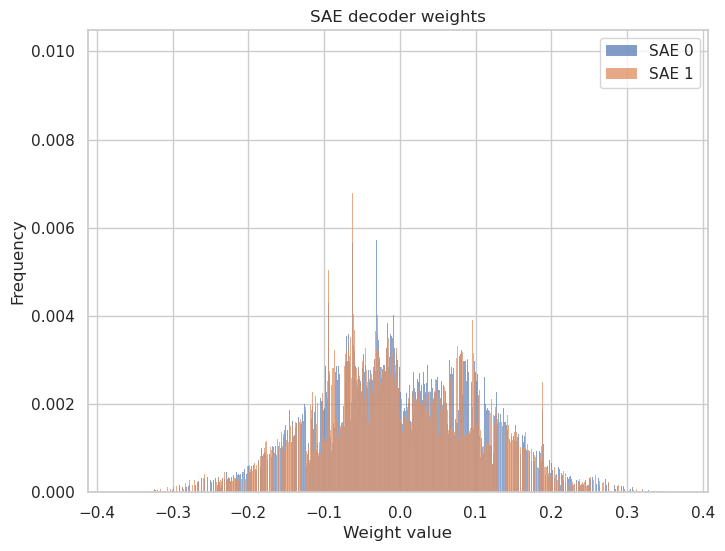

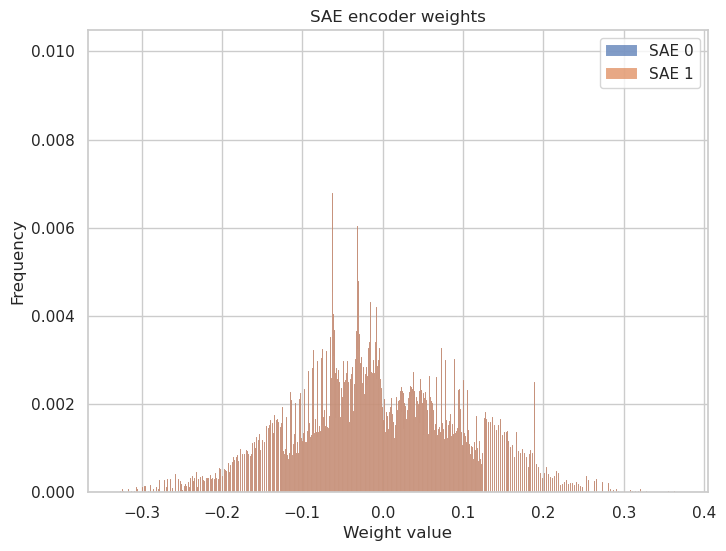

In [65]:
"""Visualize weights."""

fig, ax = plt.subplots(figsize=(8, 6))
for inst in range(n_inst):
    W_dec_flat = asnumpy(sae.W_dec[inst].float()).ravel()
    sns.histplot(W_dec_flat, bins=1000, stat="probability", alpha=0.7, label=f"SAE {inst}")
    
ax.set_title("SAE decoder weights")
ax.set_xlabel("Weight value")
ax.set_ylabel("Frequency")
ax.legend()

fig, ax = plt.subplots(figsize=(8, 6))
for inst in range(n_inst):
    W_enc_flat = asnumpy(sae.W_enc[inst].float()).ravel()
    sns.histplot(W_dec_flat, bins=1000, stat="probability", alpha=0.7, label=f"SAE {inst}")
    
ax.set_title("SAE encoder weights")
ax.set_xlabel("Weight value")
ax.set_ylabel("Frequency")
ax.legend()

SAE batch evaluation step: 100%|██████████| 18750/18750 [00:22<00:00, 838.53it/s]


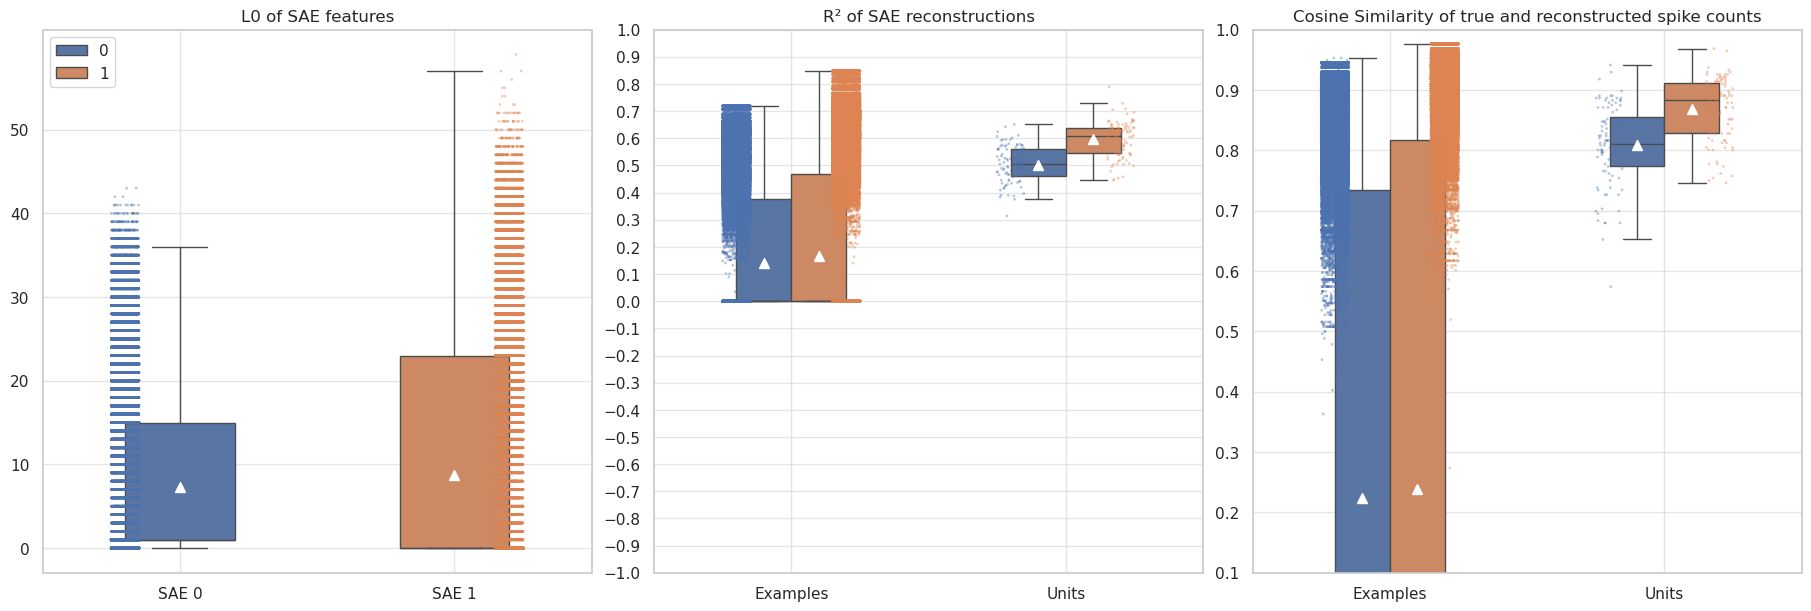

In [66]:
"""Visualize metrics over all examples and units."""

topk_acts_4d, recon_spk_cts, r2_per_unit, _, cossim_per_unit, _ = mt.eval_model(spike_cts, sae, batch_sz=batch_sz)

In [67]:
"""Calculate variance explained of summed spike counts."""

# Var explained for summed spike counts.
n_recon_examples = recon_spk_cts.shape[0]
recon_summed_spk_cts = reduce(recon_spk_cts, "example inst unit -> example inst", "sum")
actual_summed_spk_cts = reduce(spike_cts, "example unit -> example", "sum")
actual_summed_spk_cts = actual_summed_spk_cts[0:n_recon_examples]  # trim to match
for inst in range(n_inst):
    r2 = r2_score(
        asnumpy(actual_summed_spk_cts.float()), asnumpy(recon_summed_spk_cts[:, inst].float())
    )
    print(f"SAE instance {inst} R² (summed spike count over all units per example) = {r2:.3f}")

SAE instance 0 R² (summed spike count over all units per example) = 0.774
SAE instance 1 R² (summed spike count over all units per example) = 0.824


## Remove bad units and retrain

In [ ]:
"""Re-train."""

r2_thresh = 0.1
inst = 0
r2_per_unit = r2_per_unit[:, inst]
keep_mask = r2_per_unit > r2_thresh
print(f"frac units above {r2_thresh=}: {keep_mask.sum() / keep_mask.shape[0]:.2f}")
print(f"Number to keep: {keep_mask.sum()} / {keep_mask.shape[0]}")

# Remove units and retrain
spk_cts = spike_cts[:, keep_mask]

sae_cfg = mt.SaeConfig(
    n_input_ae=spk_cts.shape[1],
    dsae_topk_map=dsae_topk_map,
    dsae_loss_x_map=dsae_loss_x_map,
    seq_len=1,
    n_instances=n_inst,
)
sae = mt.Sae(sae_cfg).to(device)
loss_fn = mt.msle
tau = 1.0
lr = 5e-4

n_epochs = 20
batch_sz = 16
n_steps = spk_cts.shape[0] // batch_sz * n_epochs
log_freq = n_steps // n_epochs // 2
dead_neuron_window = n_steps // n_epochs // 3

data_log = mt.optimize(  # train model
    spk_cts=spk_cts,
    sae=sae,
    loss_fn=loss_fn,
    optimizer=t.optim.Adam(sae.parameters(), lr=lr),
    use_lr_sched=True,
    dead_neuron_window=dead_neuron_window,
    n_steps=n_steps,
    log_freq=log_freq,
    batch_sz=batch_sz,
    log_wandb=False,
    plot_l0=False,
    tau=tau
)

In [ ]:
"""Re-visualize metrics over all examples and units."""

topk_acts_4d, recon_spk_cts, r2_per_unit, _, cossim_per_unit, _ = mt.eval_model(spk_cts, sae, batch_sz=batch_sz)

n_recon_examples = recon_spk_cts.shape[0]
recon_summed_spk_cts = reduce(recon_spk_cts, "example inst unit -> example inst", "sum")
actual_summed_spk_cts = reduce(spk_cts, "example unit -> example", "sum")
actual_summed_spk_cts = actual_summed_spk_cts[0:n_recon_examples]  # trim to match
for inst in range(n_inst):
    r2 = r2_score(
        asnumpy(actual_summed_spk_cts.float()), asnumpy(recon_summed_spk_cts[:, inst].float())
    )
    print(f"SAE instance {inst} R² (summed spike count over all units per example) = {r2:.3f}")


## Interpret features

In [68]:

out_dir = Path("/workspace/SAE_place_cells/")
session_id = "31-08-2025_12_47_55"  # change to your session id

load_acts = False  # if True, will load saved feature activations
save_acts = False
sae_datafile = "sae_0.csv"  # set name of data file to load (or save to)

acts_df_save_path = out_dir / f"{session_id}" / "sae_features" / sae_datafile
acts_df_save_path.parent.mkdir(parents=True, exist_ok=True)

In [ ]:
"""Create dfs of feature activations."""

if not load_acts:

    # Convert tensor to numpy array for easier handling
    acts_array = asnumpy(topk_acts_4d)

    # Create DataFrame with the data
    acts_df = pd.DataFrame({
        "example_idx": acts_array[:, 0],
        "instance_idx": acts_array[:, 1],
        "feature_idx": acts_array[:, 2],
        "activation_value": acts_array[:, 3]
    })

    # Convert appropriate cols to ints
    acts_df["example_idx"] = acts_df["example_idx"].astype(int)
    acts_df["feature_idx"] = acts_df["feature_idx"].astype(int)
    acts_df["instance_idx"] = acts_df["instance_idx"].astype(int)

    n_recon_examples = int(acts_df.iloc[-1]["example_idx"]) + 1

print(acts_df.head(5))

In [ ]:
display(acts_df)

,example_idx,instance_idx,feature_idx,activation_value
0,0,0,5,0.125000
1,0,0,13,0.125000
2,0,0,14,0.125000
3,0,0,117,0.125000
4,0,0,144,0.125000
...,...,...,...,...
4799995,299995,0,284,0.125977
4799996,299996,0,284,0.125977
4799997,299997,0,284,0.125977
4799998,299998,0,284,0.125977


,instance_idx,feature_idx,activation_mean,activation_std,act_mean_over_std,activation_frac
0,0,5,0.165422,0.039759,4.160644,0.200230
1,0,11,0.174409,0.022496,7.752897,0.094170
2,0,13,0.167531,0.040241,4.163224,0.210087
3,0,14,0.165925,0.039118,4.241702,0.204197
4,0,18,0.192996,0.021599,8.935445,0.114893
5,0,24,0.191378,0.022048,8.680010,0.114403
6,0,26,0.147812,0.023947,6.172559,0.075987
7,0,34,0.142162,0.014030,10.132817,0.000227
8,0,60,0.188888,0.020122,9.386945,0.107197
9,0,72,0.151478,0.020831,7.271753,0.001677


In [73]:
"""Compare features from ("broad" or "general") and ("specific" or "nested") levels."""

last_feat_idx_general = list(dsae_topk_map.keys())[0]
first_feat_idx_specific = list(dsae_topk_map.keys())[1]

print(features_df[features_df["feature_idx"] < last_feat_idx_general]["activation_frac"].describe())
print()
print(features_df[np.logical_and(
    features_df["feature_idx"] > last_feat_idx_general,
    features_df["feature_idx"] < first_feat_idx_specific
)]["activation_frac"].describe())
print()
print(features_df[features_df["feature_idx"] > first_feat_idx_specific]["activation_frac"].describe())

count    33.000000
mean      0.121135
std       0.075737
min       0.000130
25%       0.075987
50%       0.119567
75%       0.191027
max       0.210087
Name: activation_frac, dtype: float64

count    41.000000
mean      0.110269
std       0.059268
min       0.000073
25%       0.069490
50%       0.107557
75%       0.172473
max       0.200927
Name: activation_frac, dtype: float64

count    60.000000
mean      0.124692
std       0.088412
min       0.000493
25%       0.093222
50%       0.113630
75%       0.174060
max       0.636263
Name: activation_frac, dtype: float64


## Hunt for features

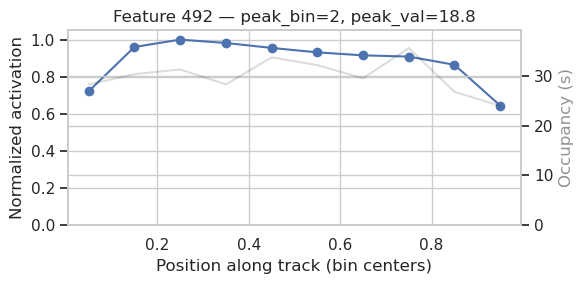

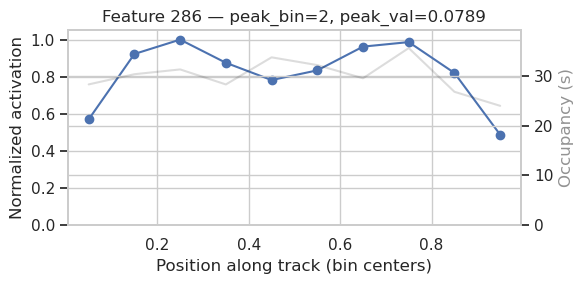

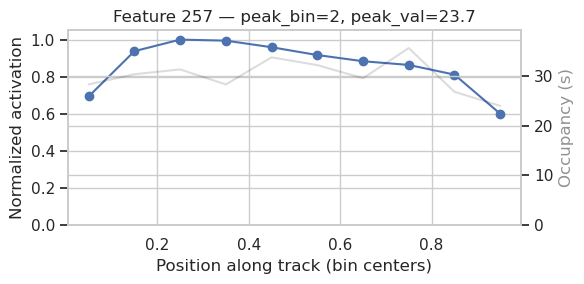

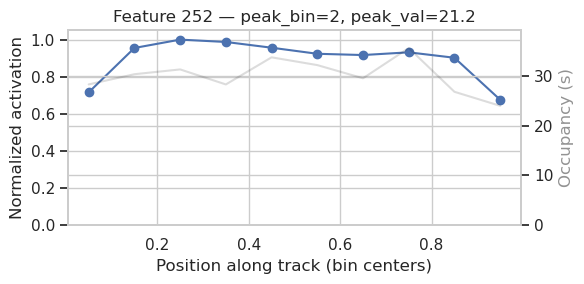

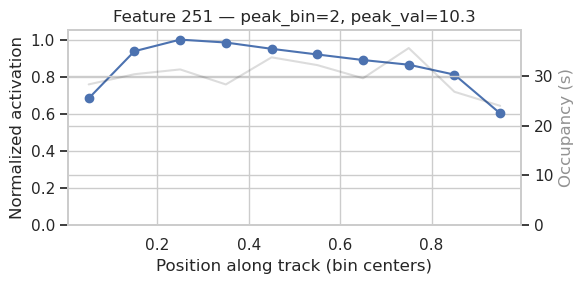

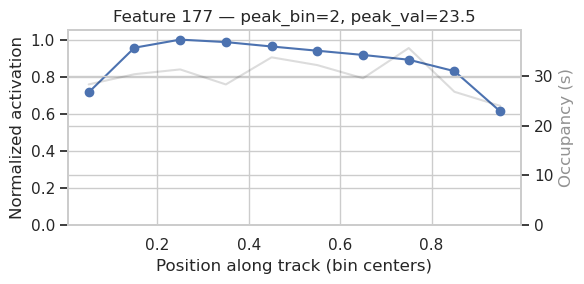

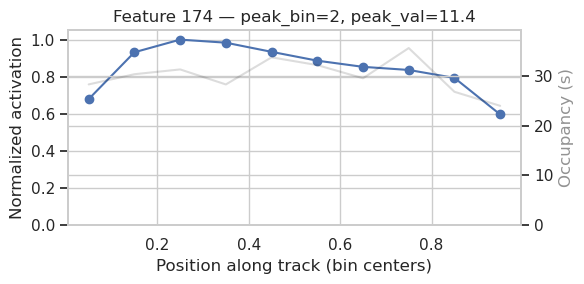

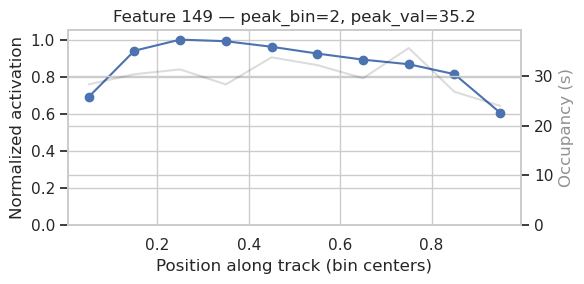

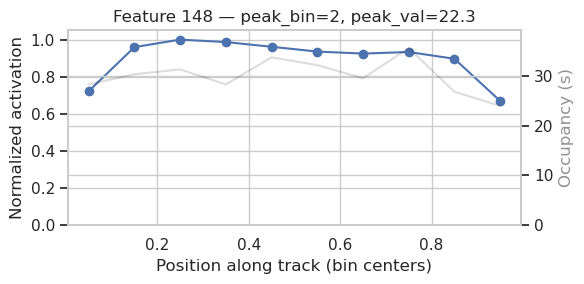

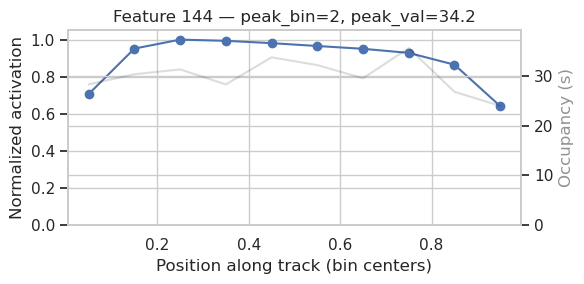

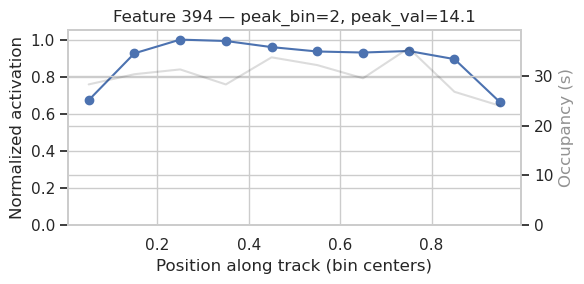

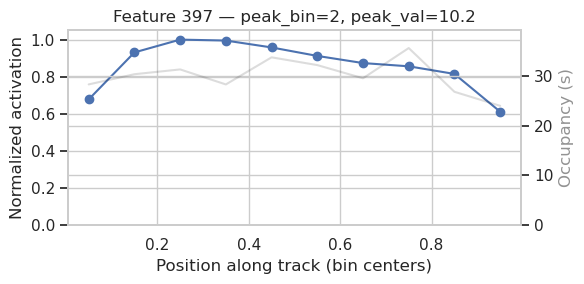

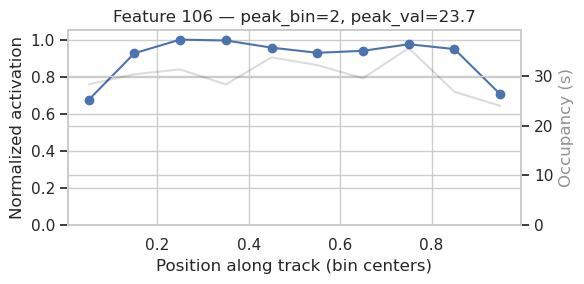

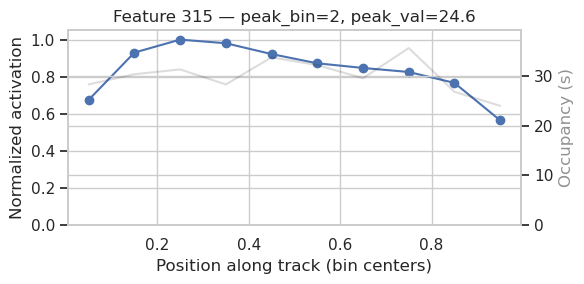

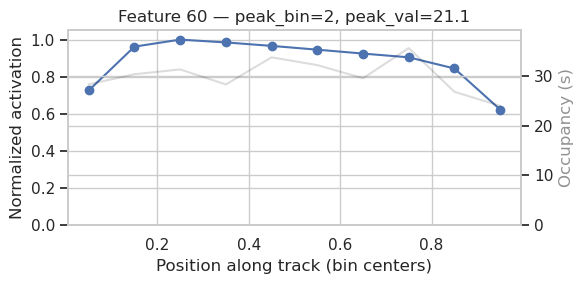

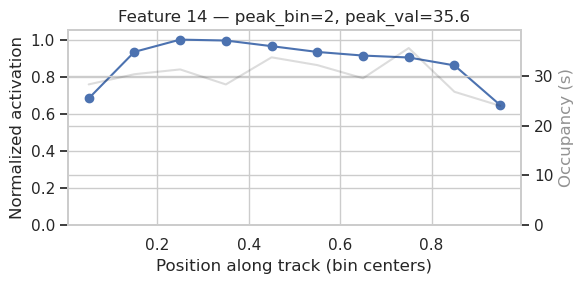

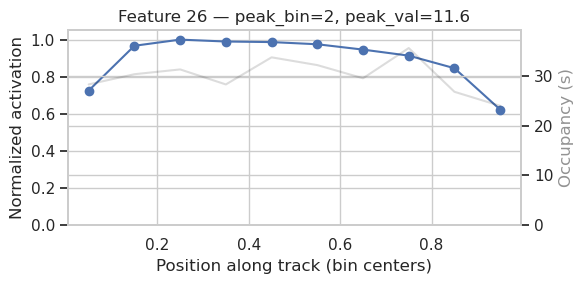

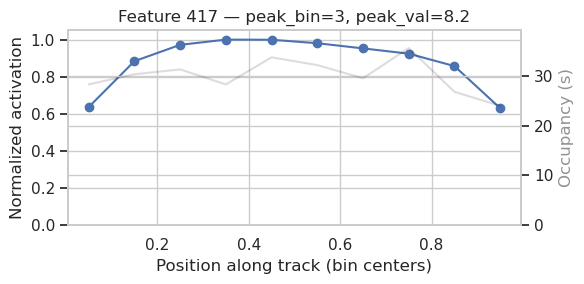

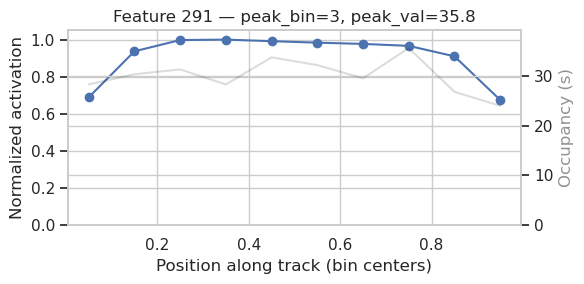

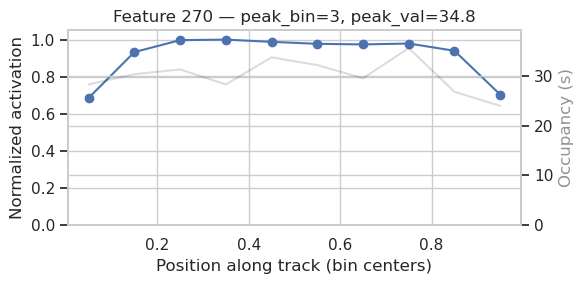

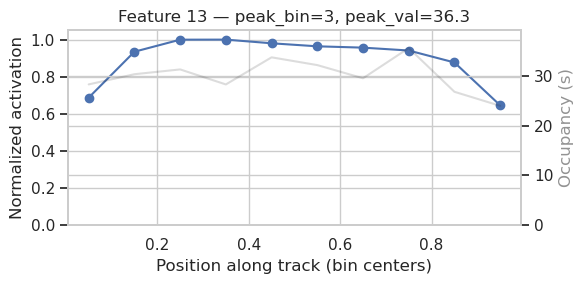

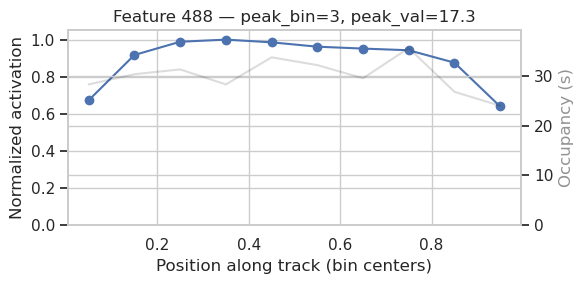

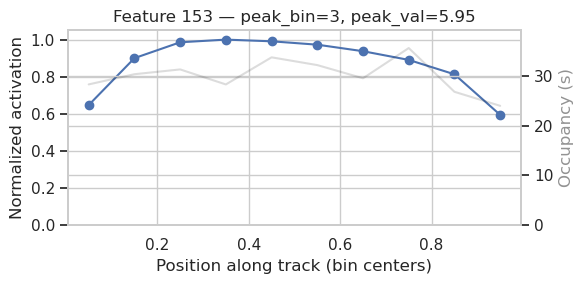

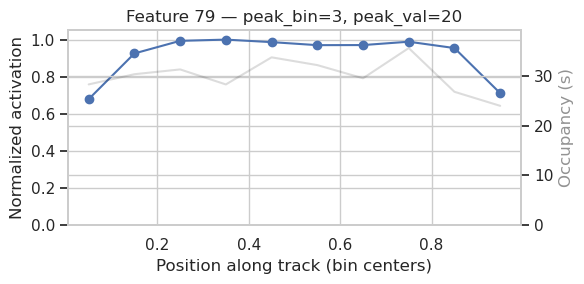

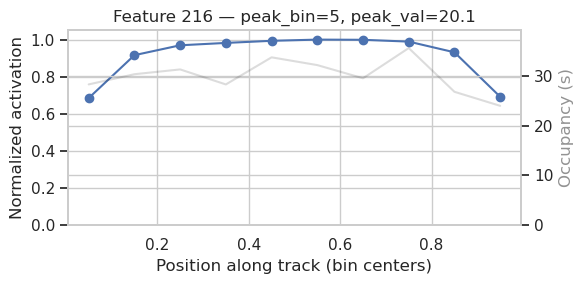

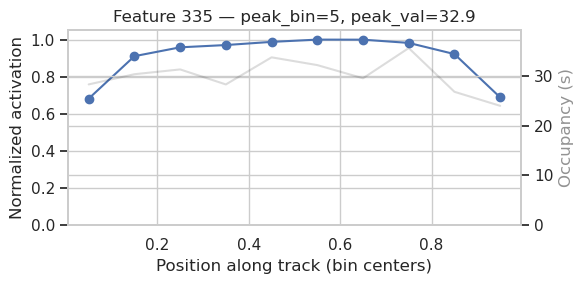

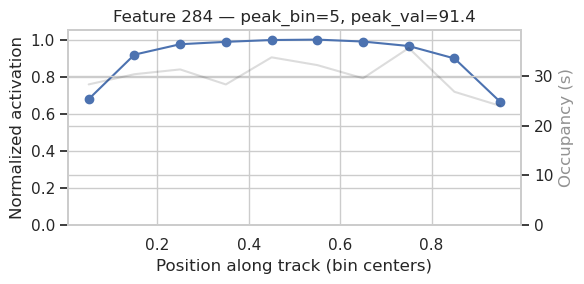

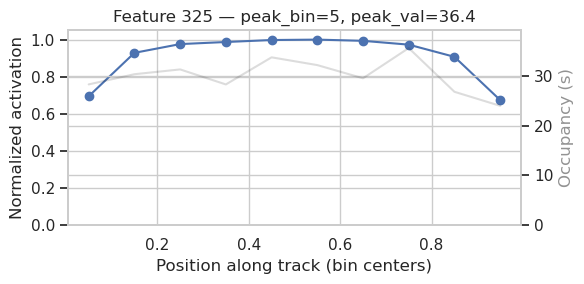

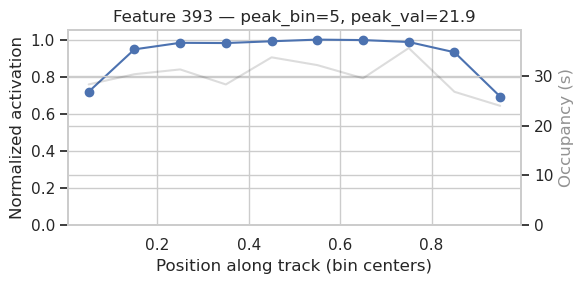

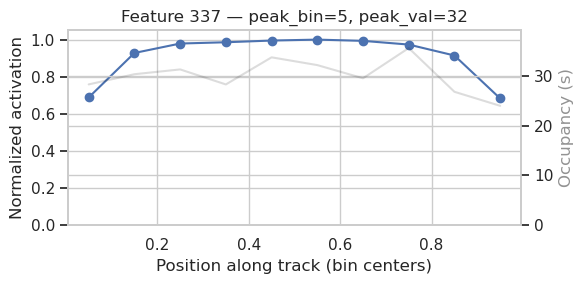

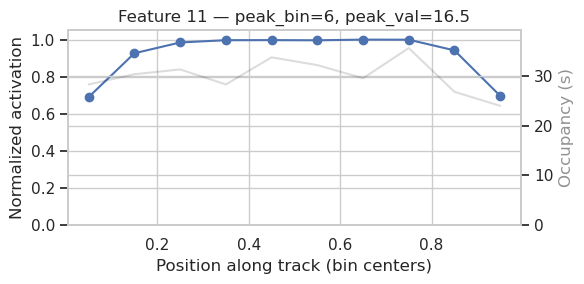

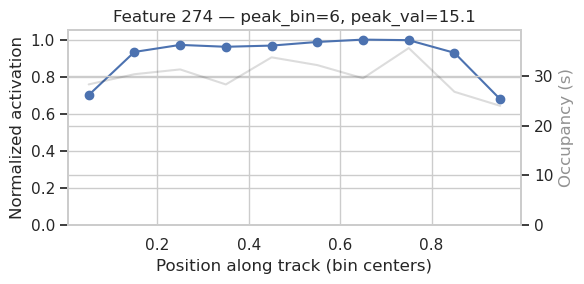

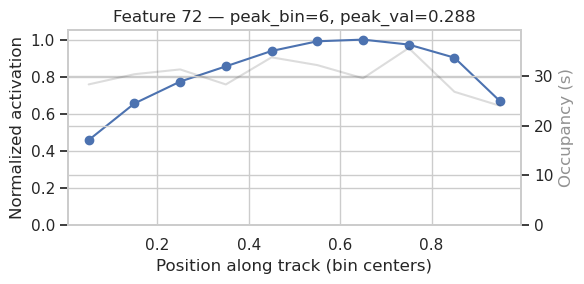

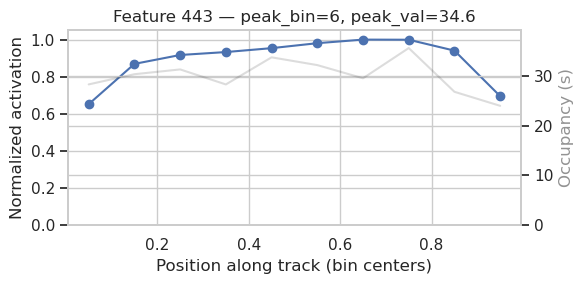

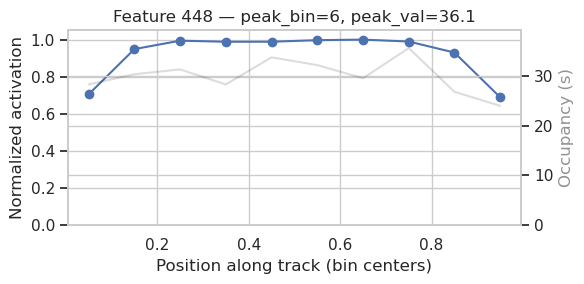

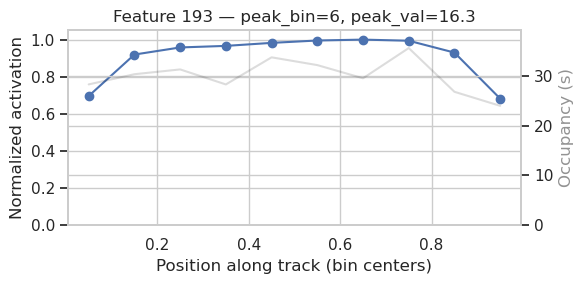

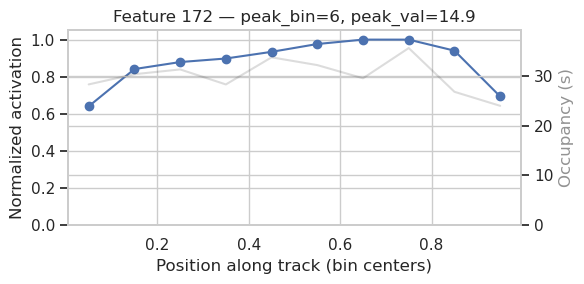

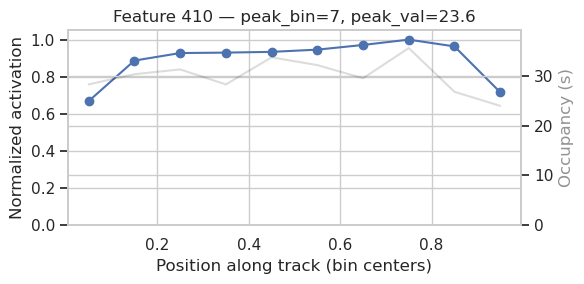

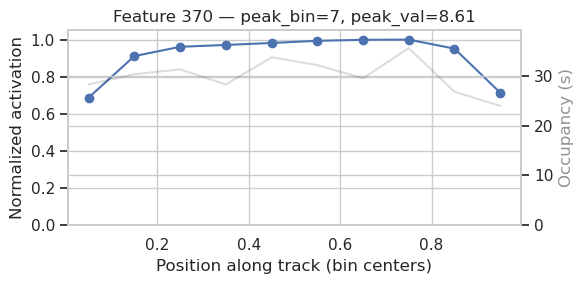

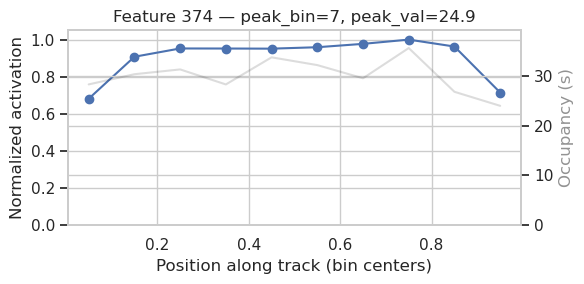

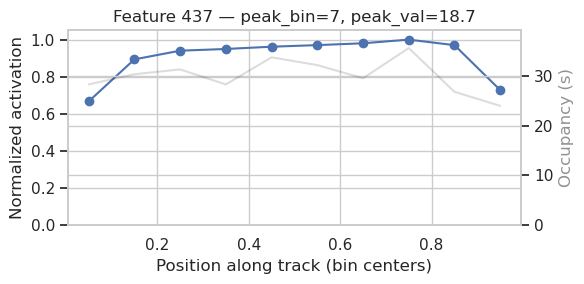

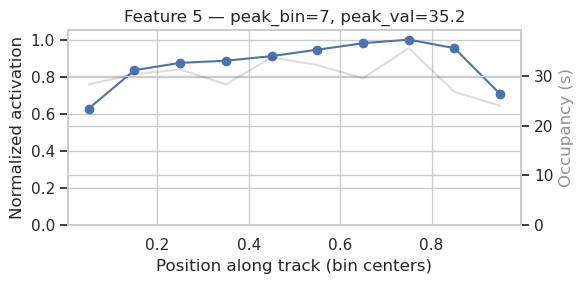

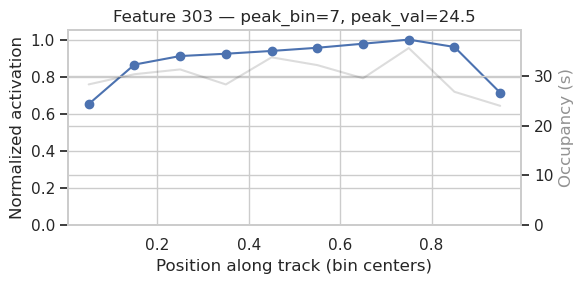

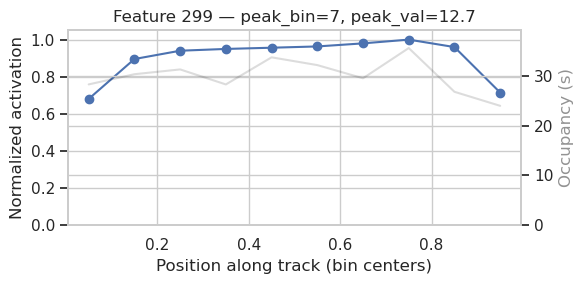

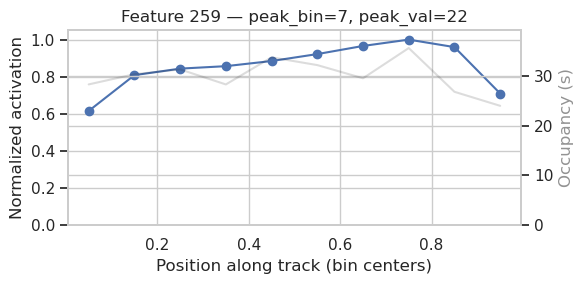

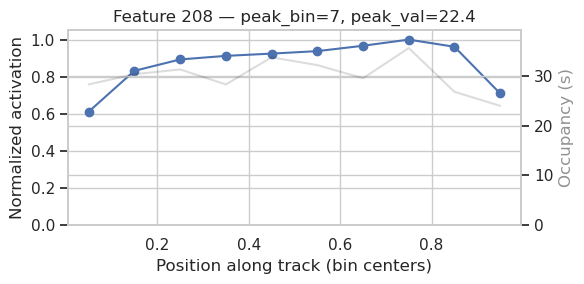

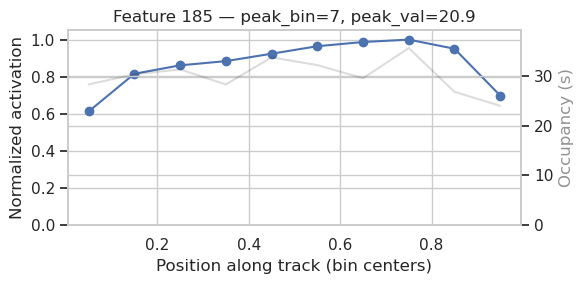

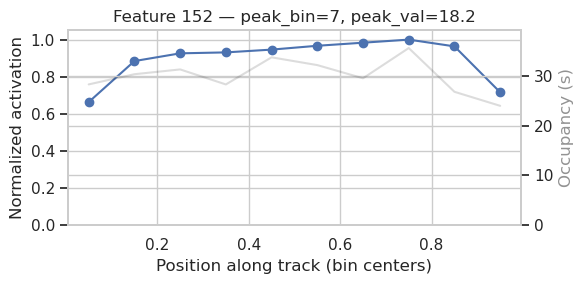

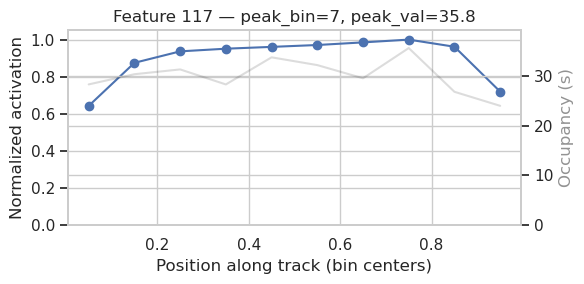

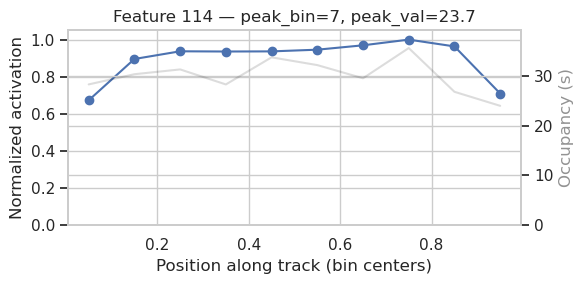

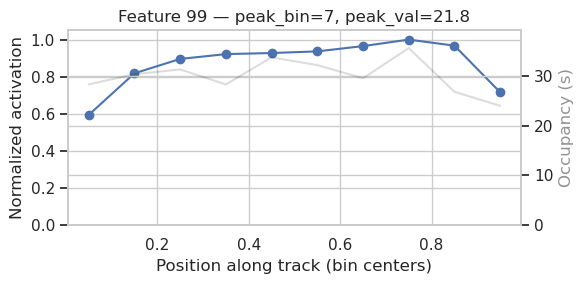

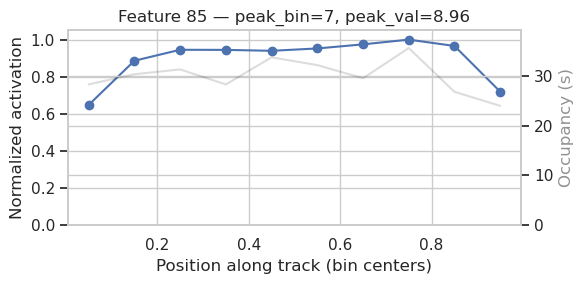

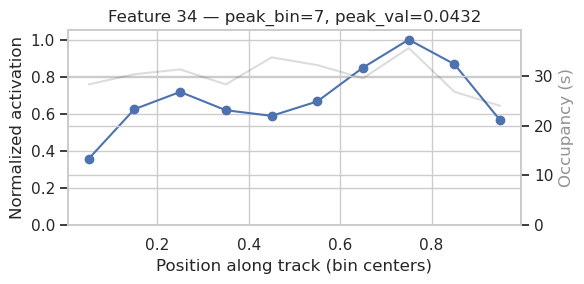

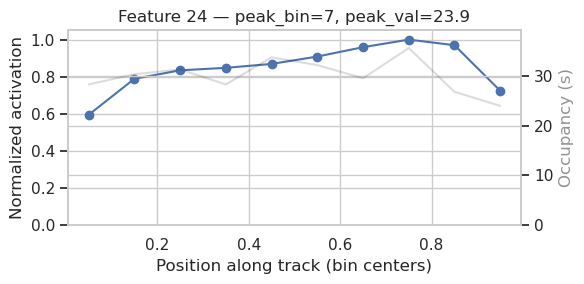

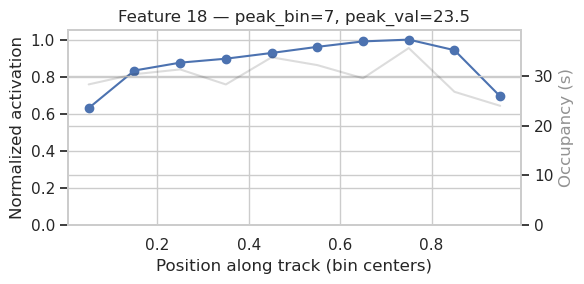

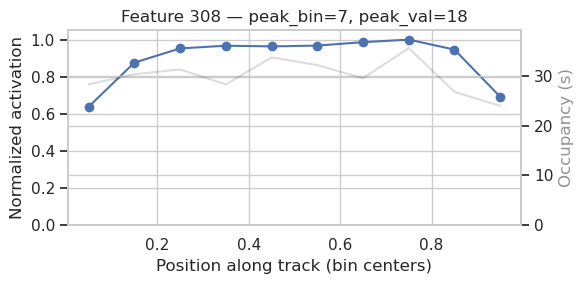

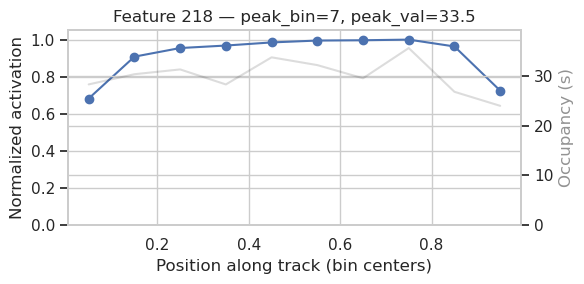

Done. Ratemaps saved to: feature_ratemaps


In [79]:
"""For a particular feature, get times it fired + stim deta at these times."""

# Inputs you already have:
# pos: shape (T,) continuous linear position
# features_df["feature_idx"]:   shape (T, F) continuous activations (or binary 0/1)
# features_df["example_idx"]:   shape (T,) time vector (optional) or assume uniform sampling dt

from scipy.ndimage import gaussian_filter1d
import os

features_df = acts_df[acts_df["instance_idx"] == 0].reset_index(drop=True)  # choose instance

# Parameters (tune as needed)
n_bins = 10
sigma_bins = 1.0            # smoothing sigma in bin units. Set to 0 to skip smoothing.
min_occupancy_s = 0.2       # seconds minimum occupancy per bin; set 0 to ignore
save_dir = "feature_ratemaps"  # set None to show inline instead of saving
row_normalize = True        # if True, scale each feature's ratemap to [0,1] for visualization
plot_type = "line"          # "line" or "bar" (per feature)
figsize = (6,3)

# -----------------------------------------------------------------------

# Basic checks
assert 'feature_idx' in features_df.columns and 'example_idx' in features_df.columns, \
    "features_df must contain 'feature_idx' and 'example_idx' columns."

# If activation values exist, use them; else create implied activation_value = 1 per row (count)
if 'activation_value' in features_df.columns:
    features_df['activation_value'] = features_df['activation_value'].astype(float)
else:
    features_df['activation_value'] = 1.0

# Convert pos & t to numpy
pos = np.load("./positions.npy")
time = np.load("./timepoints.npy")
T = len(pos)
if 'time' in globals():
    t = np.asarray(time)
    # estimate dt as median diff; if irregular sampling you might compute occupancy per-sample differently
    dt = np.median(np.diff(t))
else:
    dt = 1.0   # assume uniform sampling; occupancy in "samples" units

# 1) define spatial bins and occupancy
edges = np.linspace(pos.min(), pos.max(), n_bins + 1)
bin_idx_all = np.digitize(pos, edges) - 1
bin_idx_all = np.clip(bin_idx_all, 0, n_bins-1)

# occupancy in seconds per bin
counts = np.bincount(bin_idx_all, minlength=n_bins)
T_bins = counts * dt
p_bins = T_bins / T_bins.sum()

# optionally mask low-occupancy bins
low_occ_mask = T_bins < min_occupancy_s

# 2) Map feature activations (rows) to bins using example_idx -> pos -> bin
# Make sure example_idx is integer and indices are within range
features_df = features_df.copy()
features_df['example_idx'] = features_df['example_idx'].astype(int)
features_df = features_df[(features_df['example_idx'] >= 0) & (features_df['example_idx'] < T)].reset_index(drop=True)
# Map example -> position bin
features_df['bin'] = bin_idx_all[features_df['example_idx'].values]

# 3) Aggregate activations per feature x bin
# We compute sum of activation_value per (feature, bin). For counts-based data this is just counts.
agg = features_df.groupby(['feature_idx', 'bin'])['activation_value'].sum().unstack(fill_value=0)  # shape: (n_features, n_bins)
# ensure all bins exist as columns
agg = agg.reindex(columns=np.arange(n_bins), fill_value=0)

# 4) Convert aggregated activations to occupancy-normalized ratemap
# rate = total_activation_in_bin / occupancy_seconds_in_bin
# If dt units are samples, this gives activations per second if activation_value counted spikes per sample
occ = T_bins.copy().astype(float)
occ[occ == 0] = np.nan  # avoid division by zero; we'll mask these later
ratemap = agg.values / occ[np.newaxis, :]   # shape (n_features, n_bins)

# 5) smoothing (optional)
if sigma_bins > 0:
    # for a linear track use mode='constant' to avoid wrap-around
    ratemap_sm = gaussian_filter1d(ratemap, sigma=sigma_bins, axis=1, mode='constant')
else:
    ratemap_sm = ratemap

# 6) prepare plotting folder
if save_dir is not None:
    os.makedirs(save_dir, exist_ok=True)

# Function to compute a simple selectivity metric (peak / mean) for ordering
peak_over_mean = (ratemap_sm.max(axis=1) + 1e-12) / (np.nanmean(ratemap_sm, axis=1) + 1e-12)
# order features by peak bin (so place-like fields line up) or by peak_over_mean
peak_bin = np.nanargmax(ratemap_sm, axis=1)
order = np.argsort(peak_bin)  # primary sort by peak location
# alternative: order = np.argsort(-peak_over_mean)  # by selectivity

# 7) iterate and plot each feature's ratemap
import math
from matplotlib import gridspec

feature_ids = agg.index.values
for i_feat in order:
    feat = feature_ids[i_feat]  # actual feature_idx label (could be non-contiguous)
    row = ratemap_sm[i_feat, :].copy()
    # mask low-occupancy bins for plotting clarity
    row_vis = row.copy()
    row_vis[low_occ_mask] = np.nan

    if row_normalize:
        mx = np.nanmax(row_vis)
        if np.isfinite(mx) and mx > 0:
            row_vis = row_vis / mx

    # build plot
    fig, ax = plt.subplots(figsize=figsize)
    bins_centers = (edges[:-1] + edges[1:]) / 2.0

    if plot_type == "line":
        ax.plot(bins_centers, row_vis, marker='o', linestyle='-')
        ax.set_ylim(0, 1.05 if row_normalize else None)
    else:  # bar
        ax.bar(bins_centers, row_vis, width=(edges[1]-edges[0])*0.9, align='center')
        if row_normalize:
            ax.set_ylim(0,1.05)

    ax.set_xlabel("Position along track (bin centers)")
    ax.set_ylabel("Normalized activation" if row_normalize else "Activation / sec")
    ax.set_title(f"Feature {feat} — peak_bin={peak_bin[i_feat]}, peak_val={ratemap_sm[i_feat].max():.3g}")
    # optionally annotate occupancy under plot
    ax2 = ax.twinx()
    ax2.plot(bins_centers, T_bins, color='k', alpha=0.15)
    ax2.set_ylabel("Occupancy (s)", alpha=0.5)
    ax2.set_ylim(0, max(T_bins)*1.1)

    plt.tight_layout()
    plt.show()

    if save_dir:
        fname = os.path.join(save_dir, f"ratemap_feature_{feat}.png")
        fig.savefig(fname, dpi=150)
        plt.close(fig)

# 8) Summary DF of metrics (optional)
metrics_df = pd.DataFrame({
    "feature_idx": feature_ids,
    "peak_bin": peak_bin,
    "peak_value": ratemap_sm.max(axis=1),
    "mean_value": np.nanmean(ratemap_sm, axis=1),
    "selectivity": peak_over_mean
})
metrics_df = metrics_df.sort_values(['peak_bin', 'selectivity'], ascending=[True, False]).reset_index(drop=True)
metrics_df.to_csv(os.path.join(save_dir, "feature_ratemap_metrics.csv"), index=False)
print("Done. Ratemaps saved to:", save_dir)

